# Parallel node execution

## Review

앞서서 배운 `human-in-the loop` 은 다음과 같은 3가지 상황에 유용하게 사용됩니다.

(1) `Approval` - Agent의 중간단계에 개입해서 사용자가 계속 할지 말지 승인하는 단계를 거칩니다.

(2) `Debugging` - 되감아서 문제를 재현합니다, 디버깅에 도움을 줍니다, 개인적으로는 chatgpt 포함 수많은 Agent들이 디버깅이 사실상 불가능한 경우가 많은 것이 불만족스러웠는데, LangGraph는 디버깅이 잘 되어서 좋습니다.

(3) `Editing` - 강제로 사용자가 상태를 변경할 수도 있습니다.

## Goals

`human-in-the-loop` 과 `memory` 를 모두 사용할 것이고요.

이제 `multi-agent` workflows 로 들어갈 차례입니다.
앞서 배운 내용들을 응용하는 multi-agent research assistant 를 만들어 보겠습니다.

multi-agent research assistant 를 구현하기 위해서 LangGraph controllability 요소들 중 [parallelization](https://langchain-ai.github.io/langgraph/how-tos/branching/#how-to-create-branches-for-parallel-node-execution) 부터 살펴보겠습니다.

## Fan out and fan in

각 노드가 State를 덮어쓰는 상황을 가정해보죠.

In [ ]:
%%capture --no-stderr
%pip install -U  langgraph tavily-python wikipedia langchain_openai langchain_community langgraph_sdk

In [ ]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

OPENAI_API_KEY: ··········


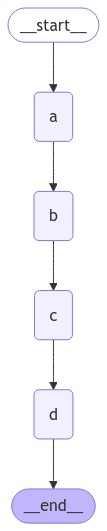

In [ ]:
from IPython.display import Image, display

from typing import Any
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END

class State(TypedDict):
    # The operator.add reducer fn makes this append-only
    state: str

class ReturnNodeValue:
    def __init__(self, node_secret: str):
        self._value = node_secret

    def __call__(self, state: State) -> Any:
        print(f"Adding {self._value} to {state['state']}")
        return {"state": [self._value]}

# Add nodes
builder = StateGraph(State)

# Initialize each node with node_secret
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

# Flow
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("b", "c")
builder.add_edge("c", "d")
builder.add_edge("d", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

State 가 계속 덮어 써지는 상황입니다.

In [ ]:
graph.invoke({"state": []})

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm B"]
Adding I'm D to ["I'm C"]


{'state': ["I'm D"]}

자, 이제 `b` 와 `c` 를 병렬로 붙이고, `d` 를 run 하겠습니다.

- fan-out from `a` to `b` and `c`
- fan-in to `d`.

어떻게 될까요...??

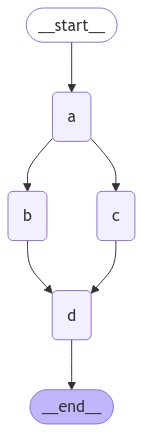

In [ ]:
builder = StateGraph(State)

# Initialize each node with node_secret
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

# Flow
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "d")
builder.add_edge("c", "d")
builder.add_edge("d", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

**당연히(?) 에러가 납니다!**



In [ ]:
from langgraph.errors import InvalidUpdateError
try:
    graph.invoke({"state": []})
except InvalidUpdateError as e:
    print(f"An error occurred: {e}")

Adding I'm A to []
Adding I'm C to ["I'm A"]
Adding I'm B to ["I'm A"]
An error occurred: At key 'state': Can receive only one value per step. Use an Annotated key to handle multiple values.


fan out 을 하면, reducer 에서 같은 channel / key 를 write 하는지 꼭 체크해야합니다.

이 상황에서는 operator.add 를 사용해서, State 를 덮어 쓰는 것이 아니라, append 하는 것이 가장 쉬운 해결 방법 이겠죠.

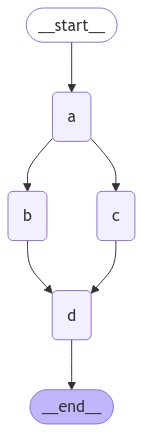

In [ ]:
import operator
from typing import Annotated

class State(TypedDict):
    # The operator.add reducer fn makes this append-only
    state: Annotated[list, operator.add]

# Add nodes
builder = StateGraph(State)

# Initialize each node with node_secret
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

# Flow
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "d")
builder.add_edge("c", "d")
builder.add_edge("d", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
graph.invoke({"state": []})

Adding I'm A to []
Adding I'm B to ["I'm A"]Adding I'm C to ["I'm A"]

Adding I'm D to ["I'm A", "I'm B", "I'm C"]


{'state': ["I'm A", "I'm B", "I'm C", "I'm D"]}

## Waiting for nodes to finish

이번에는 한쪽의 path 에 노드가 더 많이 있다고 가정해보겠습니다.

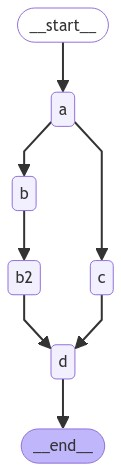

In [ ]:
builder = StateGraph(State)

# Initialize each node with node_secret
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("b2", ReturnNodeValue("I'm B2"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

# Flow
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "b2")
builder.add_edge(["b2", "c"], "d")
builder.add_edge("d", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
graph.invoke({"state": []})

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
Adding I'm B2 to ["I'm A", "I'm B", "I'm C"]
Adding I'm D to ["I'm A", "I'm B", "I'm C", "I'm B2"]


{'state': ["I'm A", "I'm B", "I'm C", "I'm B2", "I'm D"]}

## state 의 update 순서 셋팅

위 결과를 보면, B2 보다 C 가 먼저 도착했죠...? 연결된 대로 쭉쭉 이어나가서 연산되는 것이 순서인가 봅니다. 뭐 이건 랭그래프의 그래프 탐색이 이런 식으로 구현 되어 있는 것이고, 이 문서를 보고 계신 분이라면 더 설명은 없어도 되겠죠.

아무튼 그래프 탐색 순서는 컨트롤이 안됩니다.

대신 custom reducer 를 사용할 수 있죠. (sort state updates)

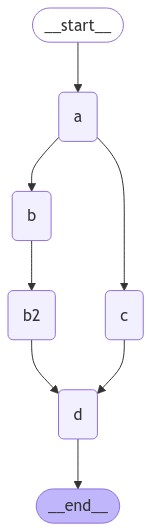

In [ ]:
def sorting_reducer(left, right):
    """ Combines and sorts the values in a list"""
    if not isinstance(left, list):
        left = [left]

    if not isinstance(right, list):
        right = [right]

    return sorted(left + right, reverse=False)

class State(TypedDict):
    # sorting_reducer will sort the values in state
    state: Annotated[list, sorting_reducer]

# Add nodes
builder = StateGraph(State)

# Initialize each node with node_secret
builder.add_node("a", ReturnNodeValue("I'm A"))
builder.add_node("b", ReturnNodeValue("I'm B"))
builder.add_node("b2", ReturnNodeValue("I'm B2"))
builder.add_node("c", ReturnNodeValue("I'm C"))
builder.add_node("d", ReturnNodeValue("I'm D"))

# Flow
builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "b2")
builder.add_edge(["b2", "c"], "d")
builder.add_edge("d", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
graph.invoke({"state": []})

Adding I'm A to []
Adding I'm B to ["I'm A"]
Adding I'm C to ["I'm A"]
Adding I'm B2 to ["I'm A", "I'm B", "I'm C"]
Adding I'm D to ["I'm A", "I'm B", "I'm B2", "I'm C"]


{'state': ["I'm A", "I'm B", "I'm B2", "I'm C", "I'm D"]}

이렇게 하면요... B2 가 나중에 추가가 되었지만, 그래도 C 보다 앞으로 들어갔습니다.
이게 좋은 방법이냐에 대해서는 이견이 있을 수 있겠지만, LangGraph 에서 공식적으로 안내하는 방법입니다.  

## LLM 에 적용하기

실전으로 가 봅시다.

위키랑 웹에서 병렬적으로 검색해서 대답을 하도록 해보죠.

In [ ]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

In [ ]:
class State(TypedDict):
    question: str
    answer: str
    context: Annotated[list, operator.add]

[Tavily](https://tavily.com/) 를 이용해서 웹 검색을 할 것이니 `TAVILY_API_KEY` 를 셋업하겠습니다.

In [ ]:
import os, getpass
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")
_set_env("TAVILY_API_KEY")

TAVILY_API_KEY: ··········


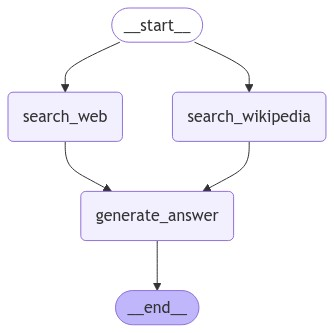

In [ ]:
from langchain_core.messages import HumanMessage, SystemMessage

from langchain_community.document_loaders import WikipediaLoader
from langchain_community.tools.tavily_search import TavilySearchResults

def search_web(state):

    """ Retrieve docs from web search """

    # Search
    tavily_search = TavilySearchResults(max_results=3)
    search_docs = tavily_search.invoke(state['question'])

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}

def search_wikipedia(state):

    """ Retrieve docs from wikipedia """

    # Search
    search_docs = WikipediaLoader(query=state['question'],
                                  load_max_docs=2).load()

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}

def generate_answer(state):

    """ Node to answer a question """

    # Get state
    context = state["context"]
    question = state["question"]

    # Template
    answer_template = """Answer the question {question} using this context: {context}"""
    answer_instructions = answer_template.format(question=question,
                                                       context=context)

    # Answer
    answer = llm.invoke([SystemMessage(content=answer_instructions)]+[HumanMessage(content=f"Answer the question.")])

    # Append it to state
    return {"answer": answer}

# Add nodes
builder = StateGraph(State)

# Initialize each node with node_secret
builder.add_node("search_web",search_web)
builder.add_node("search_wikipedia", search_wikipedia)
builder.add_node("generate_answer", generate_answer)

# Flow
builder.add_edge(START, "search_wikipedia")
builder.add_edge(START, "search_web")
builder.add_edge("search_wikipedia", "generate_answer")
builder.add_edge("search_web", "generate_answer")
builder.add_edge("generate_answer", END)
graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
result = graph.invoke({"question": "SKT의 Q2 2024 재무상태 요약해줘"})
result['answer'].content

"SK Telecom's Q2 2024 financial summary is as follows:\n\n- Revenue: KRW 4.4224 trillion (up 2.7% compared to the same period last year)\n- Operating Income: KRW 537.5 billion (up 16% year-over-year)\n- Net Income: KRW 350.2 billion\n\nThese results indicate a positive growth trend for SKT in the second quarter of 2024."

## LangGraph API

--

**⚠️ DISCLAIMER**

LangGraph Studio 가 현재 (24.9.30) 는 MACOS 만 지원합니다.

--

온라인으로 본 문서를 보시는 분들은 나중에 제가 영상으로 제작해서 올리도록 하겠습니다.

![Screenshot 2024-08-29 at 3.05.13 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb10f43c3d4df239e0278_parallelization-1.png)


# Sub-Graph

multi-agent 구현을 위해 다음 다룰 LangGraph controllable 요소는 [Sub-Graph](https://langchain-ai.github.io/langgraph/how-tos/subgraph/#simple-example) 입니다.


## State

Sub-graphs 는 State 를 나눠서 각각 관리하는 방법입니다. 이제까지는 State 를 하나만 가지고 이렇게 저렇게 다뤘었죠.

multi-agent systems, 특히 agent 들을 팀으로 이뤄서 state 를 가지고 작업 하도록 만들어 줍니다.  

간단한 예시를 살펴보겠습니다.  

* 로그를 받는 시스템입니다.
* task를 두 개로 나눠보겠습니다
  - 로그를 요약하는 task
  - 문제를 찾는 task
* 이 두가지 일을 각각 나눠서 따로따로 agent에게 시키고 싶겠죠?

각각 나눠서 일을 시키면, LLM Application 을 두 개로 구현을 하면 됩니다.
하지만 완전히 독립적인 일이 아니기 때문에 서로 소통을 하면 더 좋겠죠.  
Sub-Graph로 나눠서 일을 시키려고 하고, 문제는 두 subgraph 간의 통신입니다.

미리 말하자면, 통신은 이렇게 해결합니다, 이 파트는 원문을 정확한 전달을 위해 번역하지 않고 쓰겠습니다.
> **done with over-lapping keys**:

* The sub-graphs can access `docs` from the parent
* The parent can access `summary/failure_report` from the sub-graphs

![subgraph.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb1abf89f2d847ee6f1ff_sub-graph1.png)

## Input

로그를 받기 위한 스키마 부터 잡고 가겠습니다.

In [ ]:
from operator import add
from typing_extensions import TypedDict
from typing import List, Optional, Annotated

# The structure of the logs
class Log(TypedDict):
    id: str
    question: str
    docs: Optional[List]
    answer: str
    grade: Optional[int]
    grader: Optional[str]
    feedback: Optional[str]

# Sub Graph

sub graph 부터 하나씩 만들겠습니다.



<ipython-input-20-47ec520dc6f8>:28: LangGraphDeprecationWarning: Initializing StateGraph without state_schema is deprecated. Please pass in an explicit state_schema instead of just an input and output schema.
  fa_builder = StateGraph(input=FailureAnalysisState,output=FailureAnalysisOutputState)


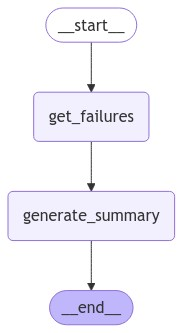

In [ ]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# Failure Analysis Sub-graph
class FailureAnalysisState(TypedDict):
    cleaned_logs: List[Log]
    failures: List[Log]
    fa_summary: str
    processed_logs: List[str]

class FailureAnalysisOutputState(TypedDict):
    fa_summary: str
    processed_logs: List[str]

def get_failures(state):
    """ Get logs that contain a failure """
    cleaned_logs = state["cleaned_logs"]
    failures = [log for log in cleaned_logs if "grade" in log]
    return {"failures": failures}

def generate_summary(state):
    """ Generate summary of failures """
    failures = state["failures"]
    # Add fxn: fa_summary = summarize(failures)
    fa_summary = "Poor quality retrieval of Chroma documentation."
    return {"fa_summary": fa_summary, "processed_logs": [f"failure-analysis-on-log-{failure['id']}" for failure in failures]}

fa_builder = StateGraph(input=FailureAnalysisState,output=FailureAnalysisOutputState)
fa_builder.add_node("get_failures", get_failures)
fa_builder.add_node("generate_summary", generate_summary)
fa_builder.add_edge(START, "get_failures")
fa_builder.add_edge("get_failures", "generate_summary")
fa_builder.add_edge("generate_summary", END)

graph = fa_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

<ipython-input-21-720cec5361d1>:24: LangGraphDeprecationWarning: Initializing StateGraph without state_schema is deprecated. Please pass in an explicit state_schema instead of just an input and output schema.
  qs_builder = StateGraph(input=QuestionSummarizationState,output=QuestionSummarizationOutputState)


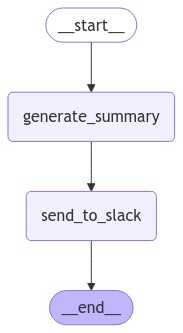

In [ ]:
# Summarization subgraph
class QuestionSummarizationState(TypedDict):
    cleaned_logs: List[Log]
    qs_summary: str
    report: str
    processed_logs: List[str]

class QuestionSummarizationOutputState(TypedDict):
    report: str
    processed_logs: List[str]

def generate_summary(state):
    cleaned_logs = state["cleaned_logs"]
    # Add fxn: summary = summarize(generate_summary)
    summary = "Questions focused on usage of ChatOllama and Chroma vector store."
    return {"qs_summary": summary, "processed_logs": [f"summary-on-log-{log['id']}" for log in cleaned_logs]}

def send_to_slack(state):
    qs_summary = state["qs_summary"]
    # Add fxn: report = report_generation(qs_summary)
    report = "foo bar baz"
    return {"report": report}

qs_builder = StateGraph(input=QuestionSummarizationState,output=QuestionSummarizationOutputState)
qs_builder.add_node("generate_summary", generate_summary)
qs_builder.add_node("send_to_slack", send_to_slack)
qs_builder.add_edge(START, "generate_summary")
qs_builder.add_edge("generate_summary", "send_to_slack")
qs_builder.add_edge("send_to_slack", END)

graph = qs_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

## Sub Graph들을 부모 Graph에 이어 붙이기

합쳐보죠.

`EntryGraphState` 로 부모 Graph를 만들고요,

노드로 다 붙여줍니다.

```
entry_builder.add_node("question_summarization", qs_builder.compile())
entry_builder.add_node("failure_analysis", fa_builder.compile())
```

In [ ]:
# Entry Graph
class EntryGraphState(TypedDict):
    raw_logs: List[Log]
    cleaned_logs: Annotated[List[Log], add] # This will be USED BY in BOTH sub-graphs
    fa_summary: str # This will only be generated in the FA sub-graph
    report: str # This will only be generated in the QS sub-graph
    processed_logs:  Annotated[List[int], add] # This will be generated in BOTH sub-graphs

`cleaned_logs` 는 왜 reducer (여기서는 add, 상태를 바꿀 수 있으니까) 가 있을까요.  subgraph 로 상태가 전달되기만 하고 바뀌지는 않을 텐데요.
```
cleaned_logs: Annotated[List[Log], add] # This will be USED BY in BOTH sub-graphs
```

subgraph의 output은 값을 바꾸지 않았더라도 **모든 keys** 를 가지고 있기 때문입니다.  

subgraph들은 병렬적으로 돌죠. 그리고, 같은 key 를 반환하기 때문에, 다시 합칠 때를 위해서 add 가 있어야 합니다.  

사실 다른 방법으로도 구현이 가능하지만, 생략하겠습니다.

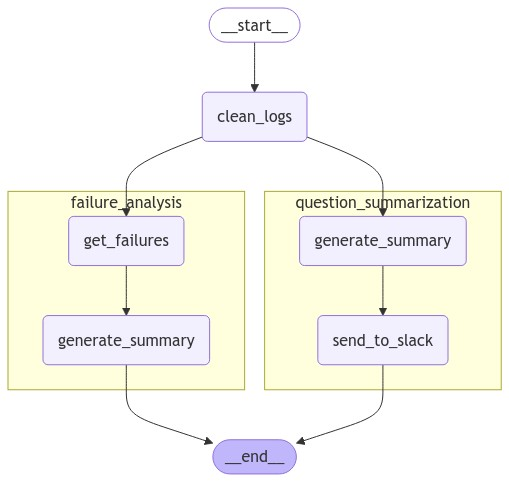

In [ ]:
# Entry Graph
class EntryGraphState(TypedDict):
    raw_logs: List[Log]
    cleaned_logs: List[Log]
    fa_summary: str # This will only be generated in the FA sub-graph
    report: str # This will only be generated in the QS sub-graph
    processed_logs:  Annotated[List[int], add] # This will be generated in BOTH sub-graphs

def clean_logs(state):
    # Get logs
    raw_logs = state["raw_logs"]
    # Data cleaning raw_logs -> docs
    cleaned_logs = raw_logs
    return {"cleaned_logs": cleaned_logs}

entry_builder = StateGraph(EntryGraphState)
entry_builder.add_node("clean_logs", clean_logs)
entry_builder.add_node("question_summarization", qs_builder.compile())
entry_builder.add_node("failure_analysis", fa_builder.compile())

entry_builder.add_edge(START, "clean_logs")
entry_builder.add_edge("clean_logs", "failure_analysis")
entry_builder.add_edge("clean_logs", "question_summarization")
entry_builder.add_edge("failure_analysis", END)
entry_builder.add_edge("question_summarization", END)

graph = entry_builder.compile()

from IPython.display import Image, display

# Setting xray to 1 will show the internal structure of the nested graph
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [ ]:
# Dummy logs
question_answer = Log(
    id="1",
    question="How can I import ChatOllama?",
    answer="To import ChatOllama, use: 'from langchain_community.chat_models import ChatOllama.'",
)

question_answer_feedback = Log(
    id="2",
    question="How can I use Chroma vector store?",
    answer="To use Chroma, define: rag_chain = create_retrieval_chain(retriever, question_answer_chain).",
    grade=0,
    grader="Document Relevance Recall",
    feedback="The retrieved documents discuss vector stores in general, but not Chroma specifically",
)

raw_logs = [question_answer,question_answer_feedback]
graph.invoke({"raw_logs": raw_logs})

{'raw_logs': [{'id': '1',
   'question': 'How can I import ChatOllama?',
   'answer': "To import ChatOllama, use: 'from langchain_community.chat_models import ChatOllama.'"},
  {'id': '2',
   'question': 'How can I use Chroma vector store?',
   'answer': 'To use Chroma, define: rag_chain = create_retrieval_chain(retriever, question_answer_chain).',
   'grade': 0,
   'grader': 'Document Relevance Recall',
   'feedback': 'The retrieved documents discuss vector stores in general, but not Chroma specifically'}],
 'cleaned_logs': [{'id': '1',
   'question': 'How can I import ChatOllama?',
   'answer': "To import ChatOllama, use: 'from langchain_community.chat_models import ChatOllama.'"},
  {'id': '2',
   'question': 'How can I use Chroma vector store?',
   'answer': 'To use Chroma, define: rag_chain = create_retrieval_chain(retriever, question_answer_chain).',
   'grade': 0,
   'grader': 'Document Relevance Recall',
   'feedback': 'The retrieved documents discuss vector stores in general, 



---



위와 마찬가지로, LangGraph Studio 로 수행을 했습니다.  
LangSmith에 찍힌 결과는 [링크](https://smith.langchain.com/public/6cc3f325-75e8-4950-92ce-ef1c3bdd9486/r) 에서 확인 가능합니다.



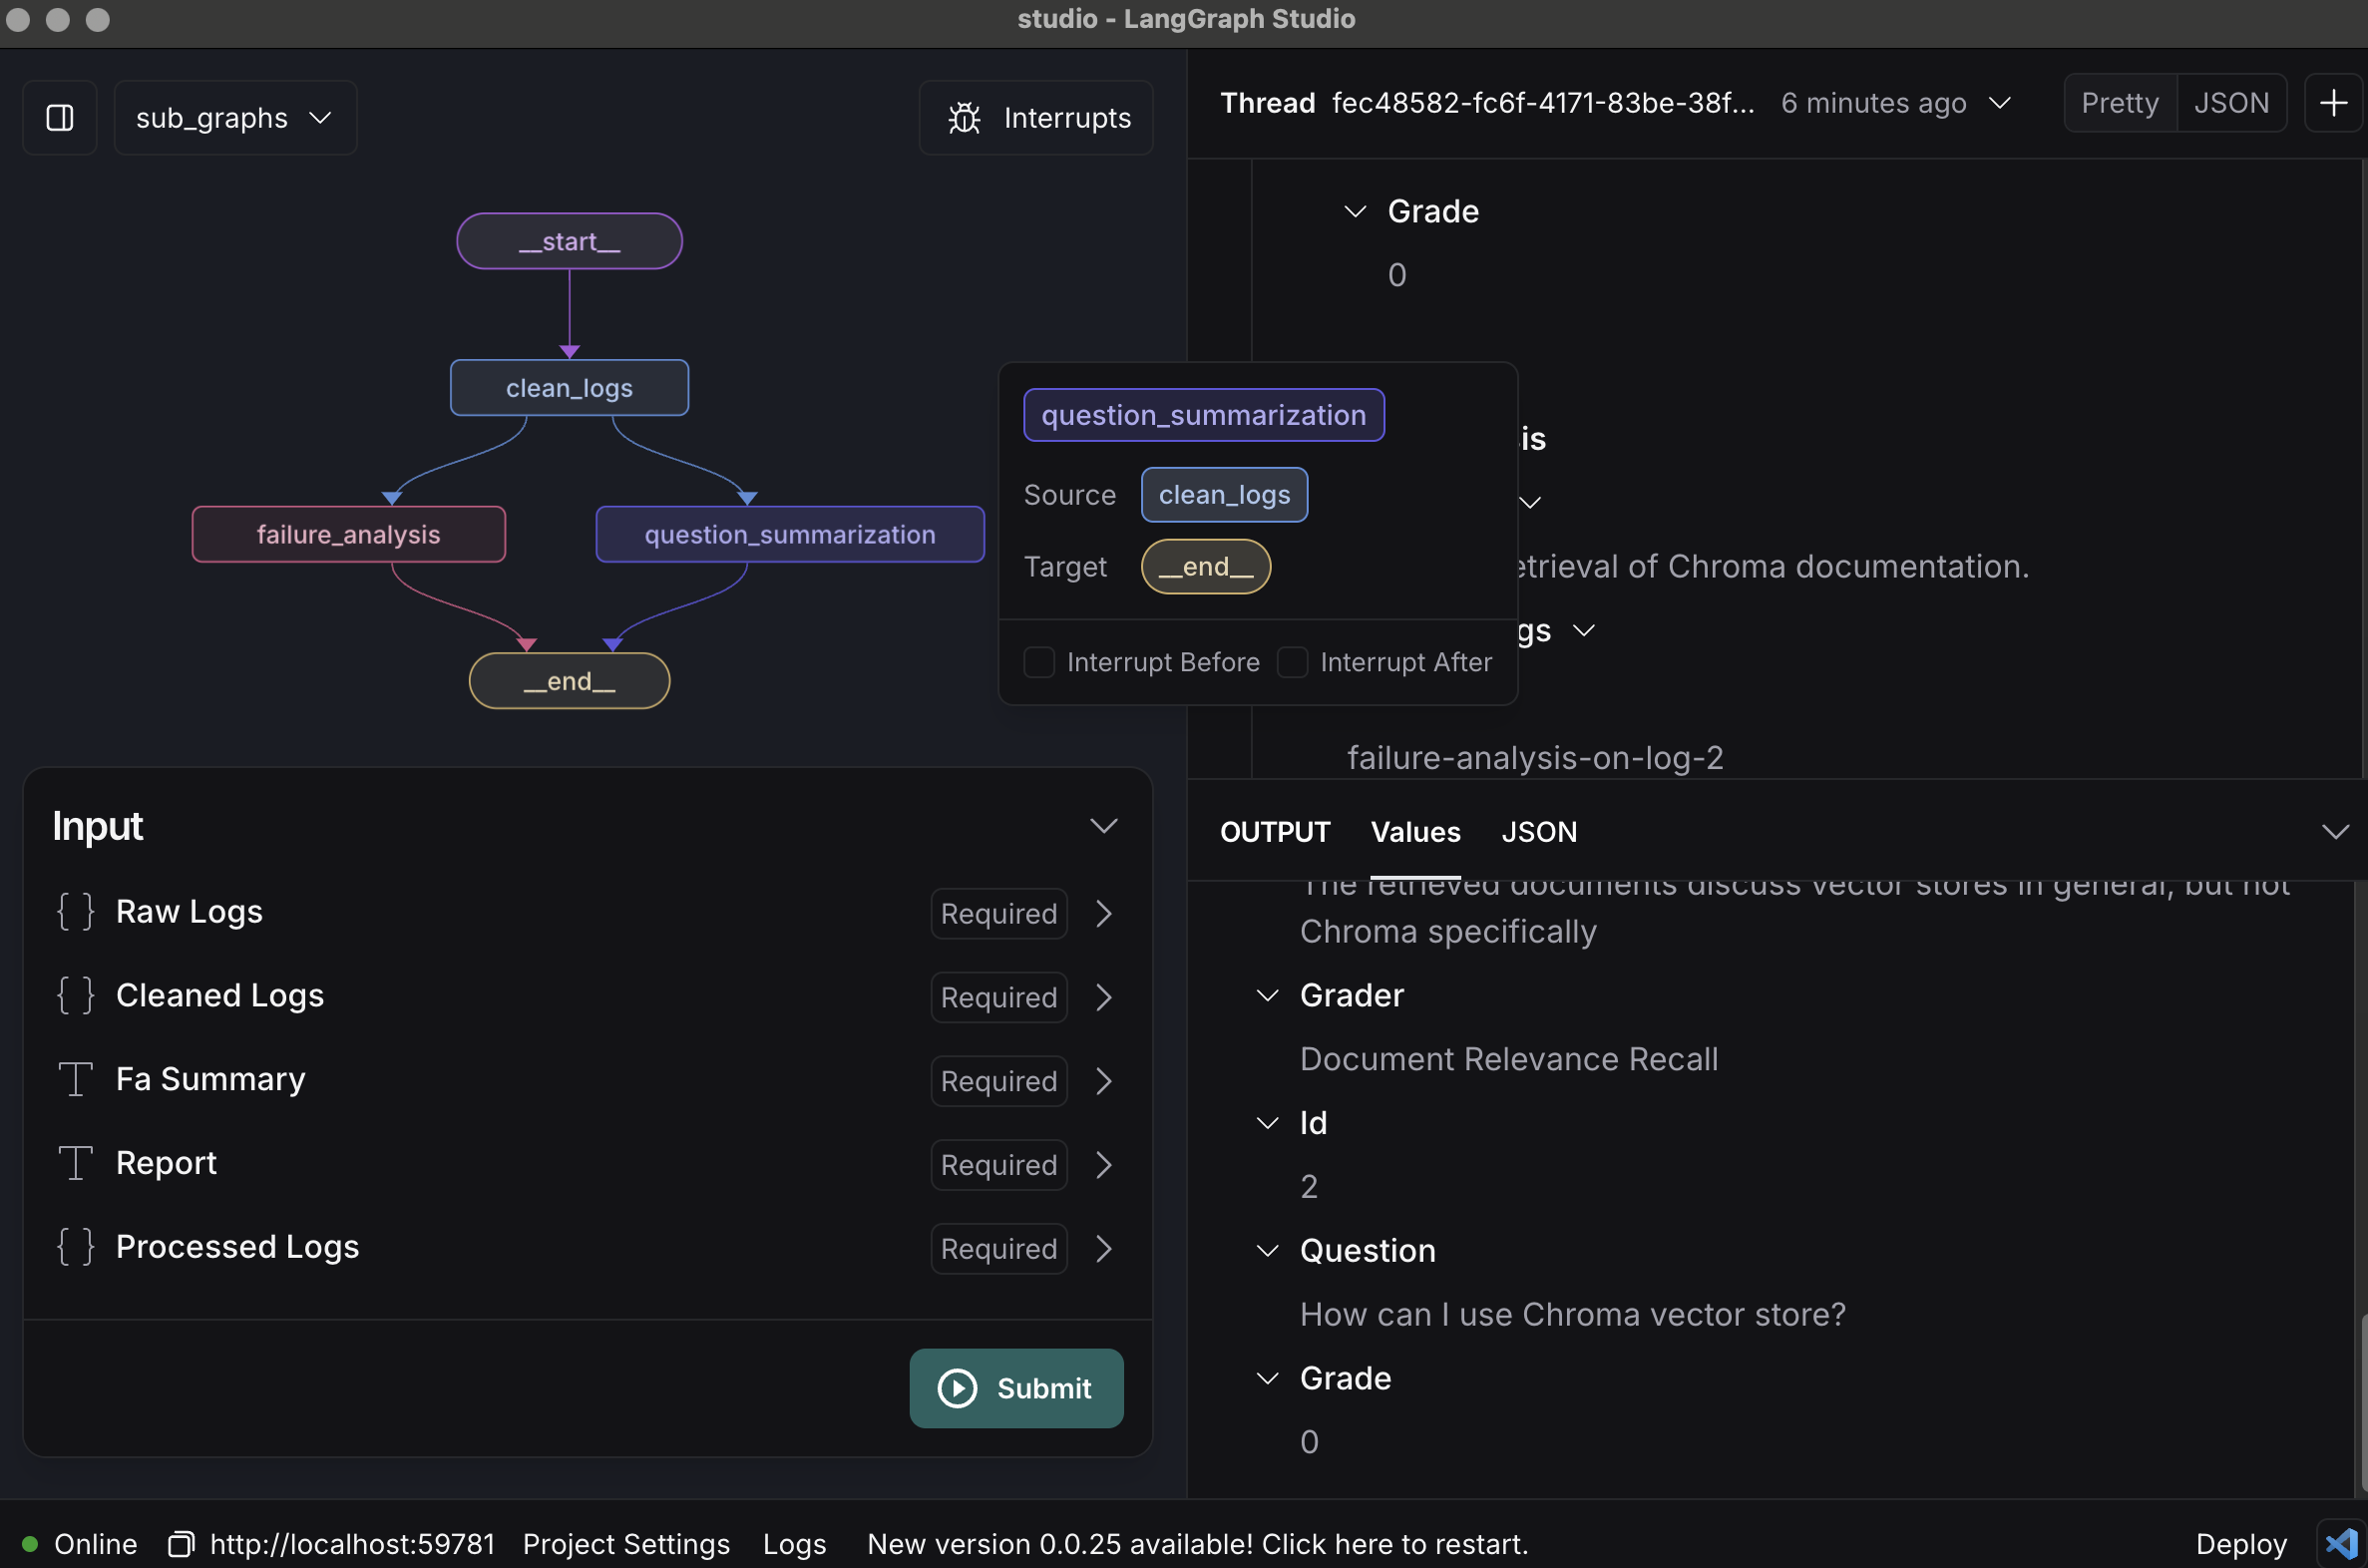

# Map-Reduce

multi-agent 구현을 위해 다음 다룰 LangGraph controllable 요소는 [Map-Reduce](https://langchain-ai.github.io/langgraph/how-tos/map-reduce/) 입니다.

## 문제 정의

Map-reduce 는 task 를 나누고 병렬적으로 시키고 돌아오는 과정에서 꼭 필요할 일입니다.


두 페이즈,

(1) `Map` - task를 작은 sub task로 나누고, 각각 처리합니다.

(2) `Reduce` - sub task의 결과들이 완료되면, aggregate 합니다.

가 있습니다.


예시를 잡고 구현해보겠습니다.  

(1) `Map` - 각 토픽들에 따라, joke를 여러개 만듧니다.

(2) `Reduce` - 생성된 joke 들을 모두 취합하고, 좋은 것만 고릅니다.

Joke 생성과 선택 모두 LLM 이 하도록 하겠습니다.



In [ ]:
from langchain_openai import ChatOpenAI

# Prompts we will use
subjects_prompt = """Generate a list of 3 sub-topics that are all related to this overall topic: {topic}."""
joke_prompt = """Generate a joke about {subject}"""
best_joke_prompt = """Below are a bunch of jokes about {topic}. Select the best one! Return the ID of the best one, starting 0 as the ID for the first joke. Jokes: \n\n  {jokes}"""

# LLM
model = ChatOpenAI(model="gpt-4o-mini", temperature=0)

## State

### 병렬적인 joke 생성

그래프 먼저 만들겠습니다.

* 유저에게 토픽을 받습니다.
* 토픽을 리스로 만들고, joke 생성 노드에 각각 보냅니다.

State 는 `jokes` 키를 가지고, 생성된 jokes 들을 취합합니다.

In [ ]:
import operator
from typing import Annotated
from typing_extensions import TypedDict
from pydantic import BaseModel

class Subjects(BaseModel):
    subjects: list[str]

class BestJoke(BaseModel):
    id: int

class OverallState(TypedDict):
    topic: str
    subjects: list
    jokes: Annotated[list, operator.add]
    best_selected_joke: str

In [ ]:
def generate_topics(state: OverallState):
    prompt = subjects_prompt.format(topic=state["topic"])
    response = model.with_structured_output(Subjects).invoke(prompt)
    return {"subjects": response.subjects}

[Send](https://langchain-ai.github.io/langgraph/concepts/low_level/#send) 를 사용해서 각각 joke 생성 노드에 토픽을 보내도록 하겠습니다.  

노드는 task 종류이고, 각 토픽에 대해 반복작업을 합니다. 이럴때 아주 유용합니다. 말하자면 for 문이죠.  

* `generate_joke`: 노드 이름
* `{"subject": s`}: 보낼 state

`Send` 는 아무 state 나 `generate_joke` 노드에 보낼 수 있습니다. `OverallState` 와 align이 될 필요가 없습니다.  

`generate_joke` 노드는 지만의 state 가 있죠.

In [ ]:
from langgraph.constants import Send
def continue_to_jokes(state: OverallState):
    return [Send("generate_joke", {"subject": s}) for s in state["subjects"]]

### Joke generation (map)

`generate_joke` 노드를 만들겠습니다. 이 친구가 map 입니다.

`OverallState` 에 `jokes` key 로 그 결과를 적어줘야 합니다.

그래야 나중에, 다 합쳐서 선택을 하겠죠.

In [ ]:
class JokeState(TypedDict):
    subject: str

class Joke(BaseModel):
    joke: str

def generate_joke(state: JokeState):
    prompt = joke_prompt.format(subject=state["subject"])
    response = model.with_structured_output(Joke).invoke(prompt)
    return {"jokes": [response.joke]}

### Best joke selection (reduce)

좋은 joke를 pick 하는 노드도 만들겠습니다. 이친구가 reduce 죠.

In [ ]:
def best_joke(state: OverallState):
    jokes = "\n\n".join(state["jokes"])
    prompt = best_joke_prompt.format(topic=state["topic"], jokes=jokes)
    response = model.with_structured_output(BestJoke).invoke(prompt)
    return {"best_selected_joke": state["jokes"][response.id]}

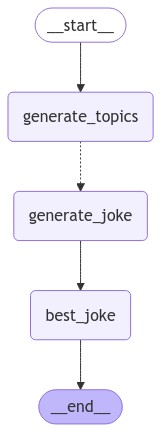

In [ ]:
from IPython.display import Image
from langgraph.graph import END, StateGraph, START

# Construct the graph: here we put everything together to construct our graph
graph = StateGraph(OverallState)
graph.add_node("generate_topics", generate_topics)
graph.add_node("generate_joke", generate_joke)
graph.add_node("best_joke", best_joke)
graph.add_edge(START, "generate_topics")
graph.add_conditional_edges("generate_topics", continue_to_jokes, ["generate_joke"])
graph.add_edge("generate_joke", "best_joke")
graph.add_edge("best_joke", END)

# Compile the graph
app = graph.compile()
Image(app.get_graph().draw_mermaid_png())

In [ ]:
# Call the graph: here we call it to generate a list of jokes
for s in app.stream({"topic": "animals"}):
    print(s)

{'generate_topics': {'subjects': ['Animal Behavior', 'Endangered Species', 'Animal Habitats']}}
{'generate_joke': {'jokes': ["Why did the fish blush? Because it saw the ocean's bottom!"]}}
{'generate_joke': {'jokes': ["Why did the dog sit in the shade? Because he didn't want to become a hot dog!"]}}
{'generate_joke': {'jokes': ['Why did the endangered species break up with their partner? Because they needed more space to thrive!']}}
{'best_joke': {'best_selected_joke': "Why did the dog sit in the shade? Because he didn't want to become a hot dog!"}}
